In [39]:
from numba import cuda
import numpy as np
import time

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

**LAB 2**

In [32]:
cuda.detect()

gpu = cuda.get_current_device()
num_processor = gpu.MULTIPROCESSOR_COUNT

print(f"Number of processors: {num_processor}")

free, total = cuda.current_context().get_memory_info()

print(f"Free: {free / (1024**3):.2f} GB")
print(f"Total {total/ (1024**3):.2f} GB")



Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-a48ae8e6-9bb2-0b37-674f-cb8f20479fae
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
Number of processors: 40
Free: 13.68 GB
Total 14.74 GB


**LAB 3**

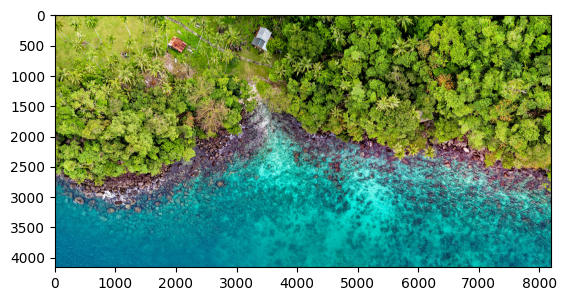

(4159, 8192, 3)
Number of pixels: 34070528
(34070528, 3)


In [33]:
import matplotlib.pyplot as plt

image_path = "image.jpg"

image = plt.imread(image_path)
plt.imshow(image)
plt.show()

print(image.shape)

H, W, C = image.shape

pixel_count = H * W

print(f"Number of pixels: {pixel_count}")

flattened_image = image.reshape(pixel_count, 3)

print(flattened_image.shape)


In [40]:
def gray_scale_cpu(flat_src):
    n = flat_src.shape[0]
    flat_dst = np.empty_like(flat_src)

    start = time.time()
    for i in range(n):
        g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)
        flat_dst[i, 0] = g
        flat_dst[i, 1] = g
        flat_dst[i, 2] = g
    end = time.time()


    return flat_dst, (end - start)

/tmp/ipython-input-2903683628.py:7: RuntimeWarning: overflow encountered in scalar add
  g = np.uint8((flat_src[i, 0] + flat_src[i, 1] + flat_src[i, 2]) / 3)


CPU grayscale done in 95.3710s


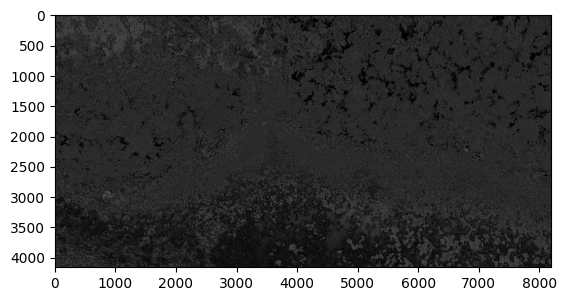

In [41]:
gray_cpu_flatten, cpu_time = gray_scale_cpu(flattened_image)
print(f"CPU grayscale done in {cpu_time:.4f}s")
gray_cpu_image = gray_cpu_flatten.reshape(H, W, C)
plt.imshow(gray_cpu_image)
plt.show()

In [42]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def grayscale_kernel(src, dst):
    i = cuda.grid(1)
    if i < src.shape[0]:
        g = np.uint8((src[i,0] + src[i,1] + src[i,2]) / 3)
        dst[i,0] = g
        dst[i,1] = g
        dst[i,2] = g

def grayscale_gpu(flat_img, nthreads=256):
    n = flat_img.shape[0]
    blocks = (n + nthreads - 1) // nthreads

    d_src = cuda.to_device(flat_img)
    d_dst = cuda.device_array_like(flat_img)

    start = time.time()
    grayscale_kernel[blocks, nthreads](d_src, d_dst)
    cuda.synchronize()
    end = time.time()

    print(f"GPU grayscale done in {end - start:.4f}s")
    return d_dst.copy_to_host(), end - start

thread = 64
GPU grayscale done in 0.0966s
thread = 128
GPU grayscale done in 0.0085s
thread = 256
GPU grayscale done in 0.0085s
thread = 1024
GPU grayscale done in 0.0071s


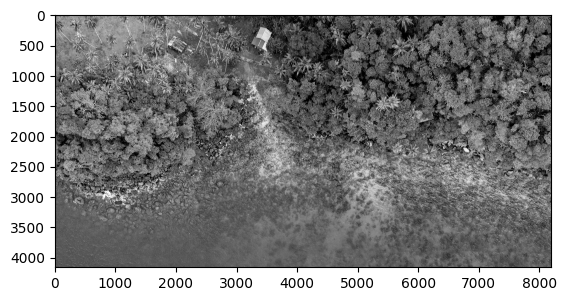

In [43]:
threads = [64, 128, 256, 1024]
time_gpu = []
result = None

for nthread in threads:
  print(f"thread = {nthread}")
  image, gpu_time = grayscale_gpu(flattened_image, nthreads=nthread)
  time_gpu.append(gpu_time)
  if result is None:
    gray_gpu_image = image.reshape(H, W, 3)
    result = gray_gpu_image


plt.imshow(result)
plt.show()

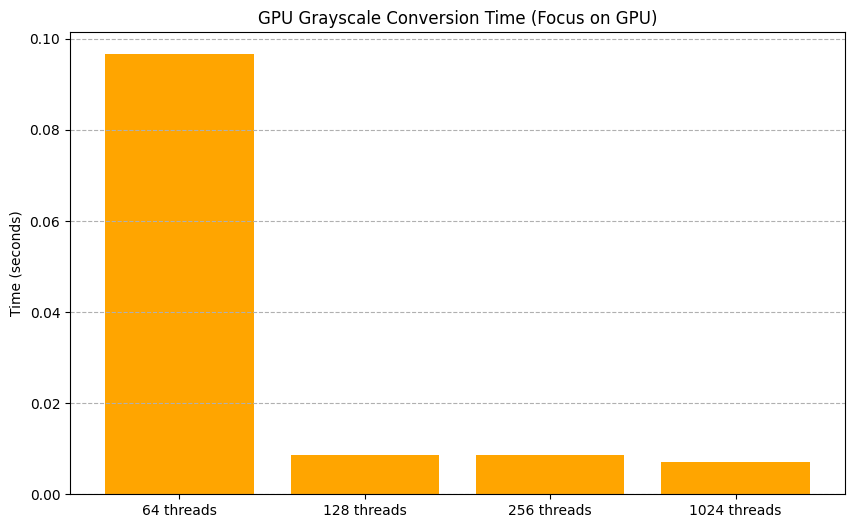

In [44]:
plt.figure(figsize=(10, 6))
plt.bar([f'{t} threads' for t in threads], time_gpu, color='orange')
plt.ylabel('Time (seconds)')
plt.title('GPU Grayscale Conversion Time (Focus on GPU)')
plt.grid(axis='y', linestyle='--')
plt.show()

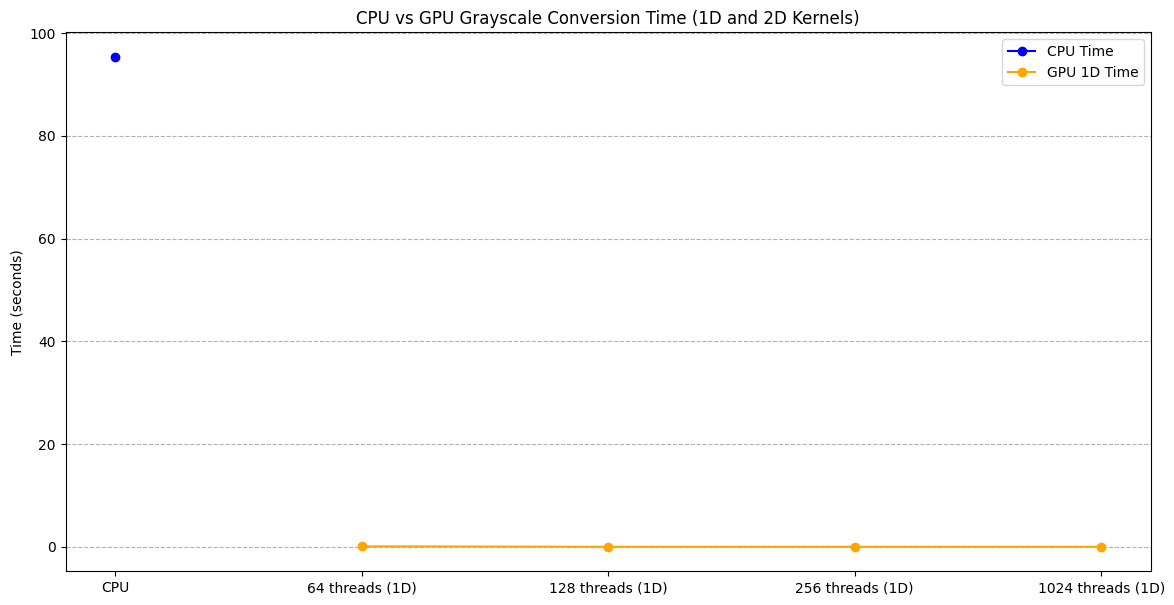

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plot
labels = ['CPU'] + [f'{t} threads (1D)' for t in threads] + [f'{t}x{t} blocks (2D)' for t in [16, 32, 64]]
times = [cpu_time] + time_gpu

plt.figure(figsize=(14, 7))
plt.plot(['CPU'], [cpu_time], marker='o', label='CPU Time', color='blue')
plt.plot([f'{t} threads (1D)' for t in threads], time_gpu, marker='o', label='GPU 1D Time', color='orange')

plt.ylabel('Time (seconds)')
plt.title('CPU vs GPU Grayscale Conversion Time (1D and 2D Kernels)')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()

**Lab 4**

In [54]:
@cuda.jit
def grayscale_kernel_2d(src, dst):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if y < src.shape[0] and x < src.shape[1]:
        r = float(src[y, x, 0])
        g = float(src[y, x, 1])
        b = float(src[y, x, 2])

        gray_val = np.uint8((r + g + b) / 3.0)

        dst[y, x, 0] = dst[y, x, 1] = dst[y, x, 2] = gray_val


def grayscale_gpu_2d(src, block_dim):
  print(f"shape = {src.shape}")
  H, W, _ = src.shape
  grid_w = (W + block_dim[0] - 1) // block_dim[0]
  grid_h = (H + block_dim[1] - 1) // block_dim[1]

  grid_dim = (grid_w, grid_h)

  d_src = cuda.to_device(src)
  d_dst = cuda.device_array_like(src)

  start = time.time()
  grayscale_kernel_2d[grid_dim, block_dim](d_src, d_dst)
  cuda.synchronize()
  end = time.time()

  elapsed_time = end - start
  print(f"GPU 2d with {block_dim} run in {elapsed_time:.4f}s")

  return d_dst.copy_to_host(), elapsed_time

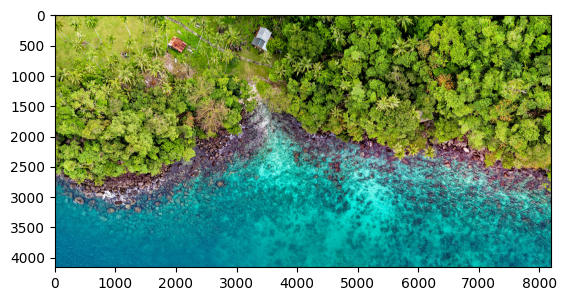

shape = (4159, 8192, 3)
GPU 2d with (16, 16) run in 0.1265s
shape = (4159, 8192, 3)
GPU 2d with (32, 32) run in 0.0129s


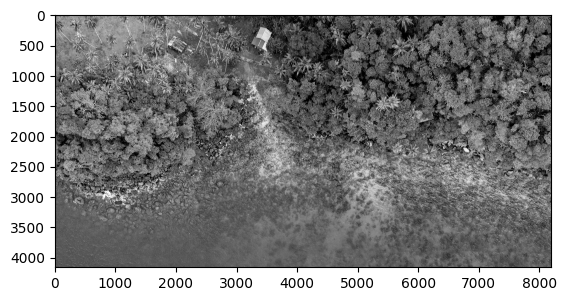

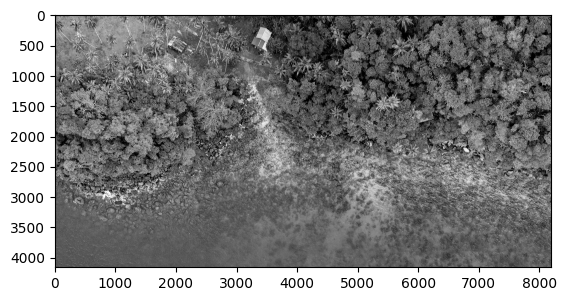

In [55]:
result_2d = []
time_2d = []

image_2d = plt.imread(image_path)
plt.imshow(image_2d)
plt.show()


for i in [(16, 16), (32,32)]:
  image_2d_result, gpu_2d_time = grayscale_gpu_2d(image_2d, block_dim=i)
  time_2d.append(gpu_2d_time)
  result_2d.append(image_2d_result)

for image in result_2d:
  plt.imshow(image)
  plt.show()